# JuliaR

### On the GLM package and similarities with R

https://github.com/angus-lewis/JuliaR

run the code from `getPackages.jl` before starting.

---

---

---

---

---

## Load our packages

In [1]:
# some other packages we need 
using Plots, GLM, IterTools, DataFrames
import RDatasets

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1260
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1260
┌ Info: Precompiling RDatasets [ce6b1742-4840-55fa-b093-852dadbb1d8b]
└ @ Base loading.jl:1260


note there is a clash between `IterTools.groupby` and `DataFrames.groupby`. 

Julia will throw an error it we try to call groupby

In [2]:
groupby(1)

UndefVarError: [91mUndefVarError: groupby not defined[39m

We must qualify with dot syntax. i.e. for the DataFrames version,  

In [3]:
DataFrames.groupby(DataFrame(a = [1;2], b = [3;4]),:b)

,a,b
,Int64,Int64
1,1,3
,a,b
,Int64,Int64
1,2,4


We also need some of our own functions

In [4]:
include("someFunctions.jl");

---

---

---

---

---

## Loading data 

In [5]:
cars = RDatasets.dataset("Mass", "Cars93")
head(cars)

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGCity,MPGHighway
,Cat…,String,Cat…,Float64,Float64,Float64,Int32,Int32
1,Acura,Integra,Small,12.9,15.9,18.8,25,31
2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25
3,Audi,90,Compact,25.9,29.1,32.3,20,26
4,Audi,100,Midsize,30.8,37.7,44.6,19,26


#### TASK: Load the cars dataset 

---

---

---

---

---

## Linear Models 

we need the `GLM` package 

In [6]:
# to save you the trouble, I have made a function to filter out rotary
# engines and convert MPG to L/100km
filter_and_convert!(cars) 
head(cars)

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,AirBags
,Cat…,String,Cat…,Float64,Float64,Float64,Cat…
1,Acura,Integra,Small,12.9,15.9,18.8,None
2,Acura,Legend,Midsize,29.2,33.9,38.7,Driver & Passenger
3,Audi,90,Compact,25.9,29.1,32.3,Driver only
4,Audi,100,Midsize,30.8,37.7,44.6,Driver & Passenger


In [7]:
lm1 = lm(@formula(City ~ Cylinders + Origin), cars)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

City ~ 1 + Cylinders + Origin

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)       6.25218     0.785153   7.96    <1e-11   4.69135    7.81301
Cylinders: 4      3.52633     0.765058   4.61    <1e-4    2.00545    5.04722
Cylinders: 5      6.70771     1.15793    5.79    <1e-6    4.40582    9.00961
Cylinders: 6      6.65738     0.788405   8.44    <1e-12   5.09009    8.22468
Cylinders: 8      7.63451     0.908325   8.41    <1e-12   5.82882    9.4402
Origin: non-USA  -0.161429    0.283094  -0.57    0.5700  -0.724202   0.401344
─────────────────────────────────────────────────────────────────────────────

To code Cylinders as a countinuous variable we use 

In [8]:
transform!(cars, :Cylinders => (x->parse.(Float64,string.(x))) => :Cylinders) |> head 

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,AirBags
,Cat…,String,Cat…,Float64,Float64,Float64,Cat…
1,Acura,Integra,Small,12.9,15.9,18.8,None
2,Acura,Legend,Midsize,29.2,33.9,38.7,Driver & Passenger
3,Audi,90,Compact,25.9,29.1,32.3,Driver only
4,Audi,100,Midsize,30.8,37.7,44.6,Driver & Passenger


In [9]:
cars[:,[:Cylinders]] |> head 

,Cylinders
,Float64
1,4.0
2,6.0
3,6.0
4,6.0


In [10]:
lm2 = lm(@formula(City ~ Cylinders + Origin), cars)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

City ~ 1 + Cylinders + Origin

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)       4.42476     0.663763   6.67    <1e-8    3.10587    5.74364
Cylinders         1.34473     0.118469  11.35    <1e-18   1.10933    1.58012
Origin: non-USA  -0.170328    0.307739  -0.55    0.5813  -0.781798   0.441142
─────────────────────────────────────────────────────────────────────────────

In [11]:
lm3 = lm(@formula(City ~ Cylinders + Origin), cars, contrasts = Dict(:Cylinders => DummyCoding()))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

City ~ 1 + Cylinders + Origin

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)       6.25218     0.785153   7.96    <1e-11   4.69135    7.81301
Cylinders: 4.0    3.52633     0.765058   4.61    <1e-4    2.00545    5.04722
Cylinders: 5.0    6.70771     1.15793    5.79    <1e-6    4.40582    9.00961
Cylinders: 6.0    6.65738     0.788405   8.44    <1e-12   5.09009    8.22468
Cylinders: 8.0    7.63451     0.908325   8.41    <1e-12   5.82882    9.4402
Origin: non-USA  -0.161429    0.283094  -0.57    0.5700  -0.724202   0.401344
─────────────────────────────────────────────────────────────────────────────

you can also get the coefficients table as a dataframe

In [12]:
using DataFrames 

In [13]:
lm1Coeffs = DataFrame(coeftable(lm1))

,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),6.25218,0.785153,7.96301,6.28417e-12,4.69135,7.81301
2,Cylinders: 4,3.52633,0.765058,4.60924,1.39341e-5,2.00545,5.04722
3,Cylinders: 5,6.70771,1.15793,5.79284,1.10963e-7,4.40582,9.00961
4,Cylinders: 6,6.65738,0.788405,8.44412,6.65588e-13,5.09009,8.22468
5,Cylinders: 8,7.63451,0.908325,8.40504,7.99074e-13,5.82882,9.4402
6,Origin: non-USA,-0.161429,0.283094,-0.57023,0.570008,-0.724202,0.401344


---

In [17]:
#using Plots

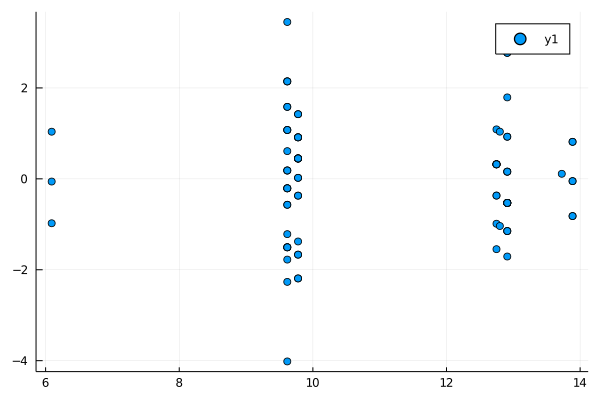

In [18]:
scatter(predict(lm1.model), residuals(lm1.model))

---

## Tasks

2) for cars which seat 5 or less passengers, fit a linear model to determine if paying more for a car gives better milage

3) with the cars data set 
 - exclude rotary cylinder engines
 - compute the city efficiency in L/100km 
 - convert :Cylinders to a continuous predictor
 - with city efficiency in L/100km as the response variable, implement an exhastive algorithm to find the linear model which fits best with the following predictors
 
 [:Weight,
 
 :Price,
 
 :Length,
 
 :FuelTankCapacity,
 
 :Wheelbase,
 
 :RPM,
 
 :Horsepower, 
 
 :EngineSize, 
 
 :Cylinders, 
 
 :City, 
 
 :Passengers]

Tips: 
 - the function `parse.(Int,"1")` converts the string `"1"` to an `Int` 
 - the function `deviance(aLinerModel)` extracts the deviance for the linear model `aLinearModel`
 - the `IterTools` package has a `subsets` function which enumeartes all subsets of a vector
 - I found it easier to specify the model matrix rather than pass an `@formula` object to `lm`

In [19]:
#Pkg.add("IterTools")
#using IterTools
vars = propertynames(cars[!,Not(:City)])
varsPowerSet = subsets(vars)

IterTools.Subsets{Array{Symbol,1}}([:Manufacturer, :Model, :Type, :MinPrice, :Price, :MaxPrice, :AirBags, :DriveTrain, :Cylinders, :EngineSize  …  :Length, :Wheelbase, :Width, :TurnCircle, :RearSeatRoom, :LuggageRoom, :Weight, :Origin, :Make, :Highway])

In [20]:
cars = CSV.File("cars.csv") |> DataFrame
filterFun(cyl) = !isequal(cyl,"rotary") # exclude rotary engines
filter!(:Cylinders => filterFun, cars) |> 
    x -> transform!(x,:MPGCity => mpg2lper100 => :City) |> 
    x -> select!(x, Not(:MPGCity)) 
transform!(cars, :Cylinders => (x->parse.(Int,x)) => :Cylinders) |> x -> first(x,5) 

UndefVarError: [91mUndefVarError: CSV not defined[39m

In [21]:
select!(cars,[:Weight,:Price,:Length,:FuelTankCapacity,
        :Wheelbase,:RPM,:Horsepower, :EngineSize, :Cylinders, :City, :Passengers]);

In [22]:
deviance(lm(Matrix(cars[:,Not([:City])]),cars[:,:City]))

65.61527965353012

In [23]:
#Pkg.add("IterTools")
vars = propertynames(cars[!,Not(:City)])
varsPowerSet = subsets(vars)

IterTools.Subsets{Array{Symbol,1}}([:Weight, :Price, :Length, :FuelTankCapacity, :Wheelbase, :RPM, :Horsepower, :EngineSize, :Cylinders, :Passengers])

In [24]:
@time begin
    AICs = []
    bestAIC = -Inf
    n = nrow(cars)
    modelSize = []
    bestExclusionVars = []
    for (index,varsSubset) in enumerate(varsPowerSet)
        if index < 1024
            excludeVars = [:City; varsSubset]
            k = ncol(cars) - length(excludeVars)
            lmDeviance = lm(Matrix(cars[:,Not(excludeVars)]),cars[:,:City]) |> deviance 
            AIC = 2*k + n*log(lmDeviance)
            push!(modelSize,k)
            push!(AICs,AIC)
        else
        end
    end
end

AICs = []
bestAIC = -Inf
n = nrow(cars)
modelSize = []
bestExclusionVars = []
for (index,varsSubset) in enumerate(varsPowerSet)
     if index < 1024
        excludeVars = [:City; varsSubset]
        k = ncol(cars) - length(excludeVars)
        lmDeviance = lm(Matrix(cars[:,Not(excludeVars)]),cars[:,:City]) |> deviance 
        AIC = 2*k + n*log(lmDeviance)
        push!(modelSize,k)
        push!(AICs,AIC)
    else
    end
end

  1.093703 seconds (3.03 M allocations: 163.354 MiB, 4.80% gc time)


In [25]:
aicWidx = DataFrame( AIC = AICs, size = modelSize, which = 1:length(AICs))

sort!(aicWidx, [:AIC, :size], rev=false) |> x -> first(x,10) 

,AIC,size,which
,Any,Any,Int64
1,393.138,3,759
2,394.225,4,247
3,394.557,4,695
4,394.999,4,631
5,395.094,4,755
6,395.11,4,757
7,395.122,4,727
8,395.129,4,743
9,395.733,5,245


In [26]:
[varsPowerSet[759];:City]

MethodError: [91mMethodError: no method matching getindex(::IterTools.Subsets{Array{Symbol,1}}, ::Int64)[39m

In [27]:
bestModel = propertynames(cars[:,Not([varsPowerSet[759];:City])])
deviance(lm(Matrix(cars[:,bestModel]),cars[:,:City]))

MethodError: [91mMethodError: no method matching getindex(::IterTools.Subsets{Array{Symbol,1}}, ::Int64)[39m

In [28]:
bestModel

UndefVarError: [91mUndefVarError: bestModel not defined[39m

In [29]:
lm(@formula(City ~ Weight + Cylinders + FuelTankCapacity),cars)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

City ~ 1 + Weight + Cylinders + FuelTankCapacity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error     t  Pr(>|t|)     Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)       0.215911    0.492209     0.44    0.6620  -0.762251     1.19407
Weight            0.00181091  0.000421543  4.30    <1e-4    0.000973182  0.00264864
Cylinders         0.326235    0.115657     2.82    0.0059   0.0963907    0.55608
FuelTankCapacity  0.217604    0.0650716    3.34    0.0012   0.0882881    0.34692
───────────────────────────────────────────────────────────────────────────────────